In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
#from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import glob

In [2]:
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
sources = r['source_id']

## Light Curves for Leavitt's Harvard Varriables

In [4]:
lea = np.loadtxt('simbad_leavitt.txt',skiprows=1,dtype=np.int64)
HVs = lea[:,0]
HVs_gaia = lea[:,1]

In [5]:
for i in range(0, len(HVs)):
    #ind = np.argwhere(source_id==HVs_gaia[i])
    #if len(ind) == 0:
        #continue
    per = r['pf'][np.argwhere(r['source_id']==HVs_gaia[i])]
    per = per#[0][0]
    if str(per) == '--':
        continue
    #print('HV = ',str(HVs[i]),'Per = ',str(per))

## The case for RMC1 (Per = 127d)

In [29]:
rmc1 = 4685821487608191104
print(r['source_id'==rmc1]['pf'])
per = r['pf'][np.argwhere(r['source_id']==rmc1)]
print(per)
#above demonstrates BAD code formatting!! Must fix when loop does not apply.
#print(np.argwhere(r['source_id']==3046774762417915136))
print(r['pf'][np.argwhere(r['source_id']==3046774762417915136)])
#print(np.argwhere(r['source_id']==rmc1))

4.940520990791141
pf [1]
  d   
------
      pf [1]      
        d         
------------------
4.6782999640058325


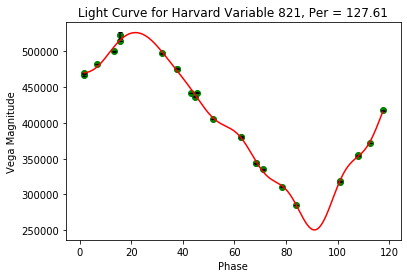

In [20]:
#mysource = 2936194782069439872
mysource = 4685821487608191104

#file = 'lcs_2930.txt'
file = 'lcs_46856_RMC1.txt'
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(0,3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
time = lcs[:,1]
mag = lcs[:,2]
flux = lcs[:,3]
flux_error = lcs[:,4] 
#per = r['pf'][np.argwhere(r['source_id']==mysource)]
#per = per[0][0]
per_tab = r['source_id'==mysource]['pf']
per_lea = 127.0
per = 127.61 #Taken from EVS_CAT
#per = per_tab #This table value is NOT for RMC1, is is for the first source in table.

asas_ind = np.argwhere(source_id==mysource)
mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
time = time[asas_ind[0][0]:asas_ind[-1][0]]
flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
#Seperating bands
band = band[asas_ind[0][0]:asas_ind[-1][0]]
G_ind = np.argwhere(band=='G')
time_G = time[G_ind[0][0]:G_ind[-1][0]]
mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]

###Three Degree Fourier Fit

myt = time_G % per
data = flux_G
N = len(data)
#first guesses
guess_freq = 1
guess_amp = 3*np.std(data)/(2**0.5)
guess_offset = np.mean(data)
p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]

#create the function we want to fit

def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,offset):
    freq = 1/per
    deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
    deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
    deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
    deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
    deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
    deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
    deg7 = (np.sin(2*np.pi*7*x*freq)*amp13) + (np.cos(2*np.pi*7*x*freq)* amp14)
    return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7

fit = curve_fit(my_sin, myt, data, p0=p0)

#now do the fit
fit = curve_fit(my_sin, myt, data, p0=p0)
#print(fit[0])
#recreate the fitted curve using the optimized parameters
#Plotting
phase = time_G % per
#phase = time_G
plt.errorbar(phase, flux_G, yerr=flux_error_G, ls='None', ecolor='k', capsize=2)
plt.scatter(phase, flux_G, c='g')
x = np.linspace(min(phase),max(phase),num=3125)
fitcurve = my_sin(x, *fit[0])
plt.plot(x, fitcurve, c='r')
plt.title('Light Curve for Harvard Variable 821, Per = 127.61')
plt.xlabel('Phase')
plt.ylabel('Vega Magnitude')
plt.savefig('HV821'+str('%.3f'%per)+'_Deg7.png', bbox_inches='tight', dpi=300)
plt.show()

## Seven Degree Fourier Fit For Loop

In [128]:
def SevDegFit(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    #flux_over_error = lcs[:,4]
    
    ceph_sources = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
    for i in range(0, len(ceph_sources)):
        #if ceph_sources[i] != 2936194782069439872:
            #continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        per = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per = per[0][0]
        if str(per) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_sources[i])]
        mag_table = mag_table[0][0]
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        asas_time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        asas_mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        #Fit
        myt = asas_time_G % per
        data = asas_flux_G
        #first guesses
        guess_freq = 1
        guess_amp = 3*np.std(data)/(2**0.5)
        guess_offset = np.mean(data)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]
        #create the function we want to fit
        def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,offset):
            freq = 1/per
            deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
            deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
            deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
            deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
            deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
            deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
            deg7 = (np.sin(2*np.pi*7*x*freq)*amp13) + (np.cos(2*np.pi*7*x*freq)* amp14)
            return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        #now do the fit
        fit = curve_fit(my_sin, myt, data, p0=p0)
        #print(fit[0])
        #repeat for magnitude
        data2 = asas_mag_G
        guess_freq2 = 1
        guess_amp2 = 3*np.std(data2)/(2**0.5)
        guess_offset2 = np.mean(data2)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_offset2]
        fit2 = curve_fit(my_sin, myt, data2, p0=p02)
        #print(fit2[0])
       
        C_flux = fit[0][-1]
        first_mag = asas_mag_G[0]
        first_flux = asas_flux_G[0]
        conversion = -2.5*np.log10(first_flux)-first_mag 
        #C_calc = conversion #- 2.5*np.log10(C_flux) - conversion
        
        #recreate the fitted curve using the optimized parameters
        #Plotting flux
        phase = asas_time_G % per
        plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, asas_flux_G, c='g')
        x = np.linspace(min(phase),max(phase),num=3125)
        fitcurve = my_sin(x, *fit[0])
        plt.plot(x, fitcurve, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_flux.png', bbox_inches='tight', dpi=300)
        plt.show()
        #Plotting mag
        plt.scatter(phase, asas_mag_G, c='b')
        fitcurve2 = my_sin(x, *fit2[0])
        plt.plot(x, fitcurve2, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_mag.png', bbox_inches='tight', dpi=300)
        plt.show()
        av_mag_mag = np.mean(fitcurve2)
        av_mag_flux = -2.5*np.log10((np.mean(fitcurve)))
        first_mag_flux = -2.5*np.log10((np.mean(first_flux)))
        C_flux_conv = -2.5*np.log10((C_flux))
        #C_calc = av_mag_flux - conversion
        #C_calc = first_mag_flux - conversion
        C_calc = C_flux_conv - conversion
        print('C_mag = ' + str(fit2[0][-1]))
        print('C_flux = ' + str(fit[0][-1]))
        #print(first_mag)
        #print(first_flux)
        print('Conversion = '+str(conversion))
        print('C_flux_converted = ' + str(C_calc))
        print('int_avg_mag = '+str(mag_table))

In [79]:
#SevDegFit('lcs_3044.txt')

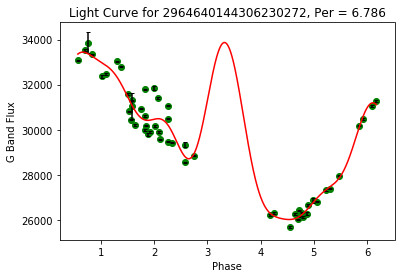

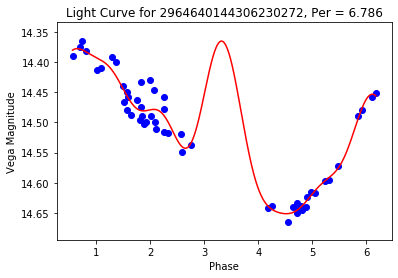

C_mag = 14.501384348696604
C_flux = 29943.396229089445
Conversion = -25.688365725119546
C_flux_converted = 14.497613082137427
int_avg_mag = 14.508817016968013


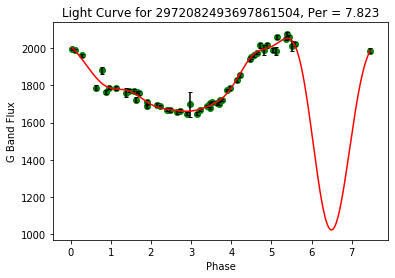

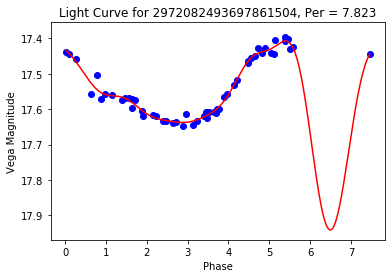

C_mag = 17.575400839050936
C_flux = 1747.4959562976746
Conversion = -25.688365725119546
C_flux_converted = 17.582325276463855
int_avg_mag = 17.505344124281315


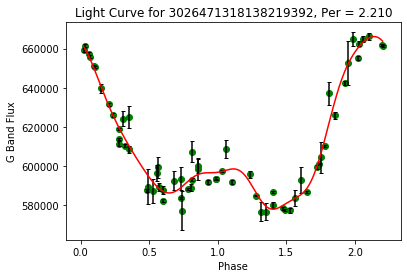

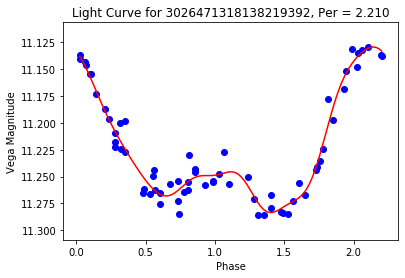

C_mag = 11.225348406631102
C_flux = 610483.0071496255
Conversion = -25.688365725119546
C_flux_converted = 11.224181775563315
int_avg_mag = 11.23114536272185


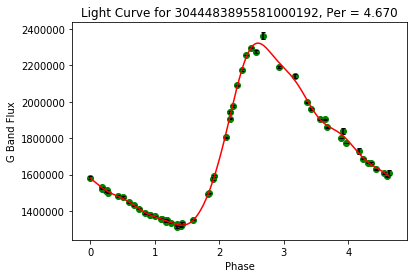

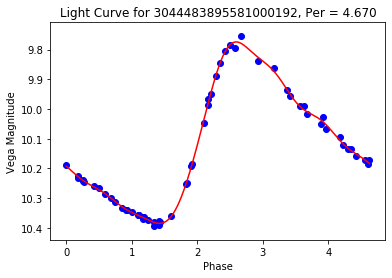

C_mag = 10.109305882418688
C_flux = 1733216.48350624
Conversion = -25.688365725119546
C_flux_converted = 10.091233698426487
int_avg_mag = 10.08493116189138


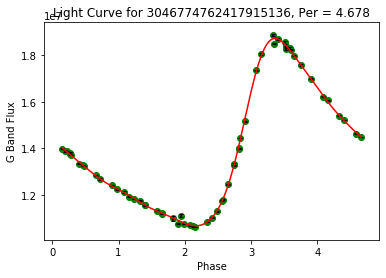

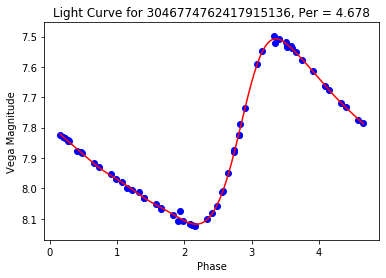

C_mag = 7.845982404081447
C_flux = 13937749.585596804
Conversion = -25.688365725119546
C_flux_converted = 7.827884081506323
int_avg_mag = 7.830550402788656


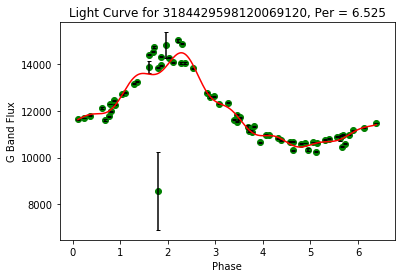

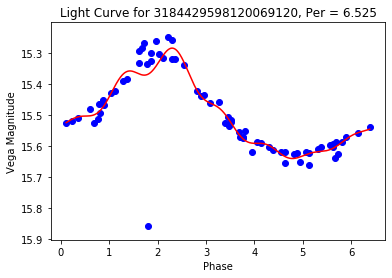

C_mag = 15.498494014239228
C_flux = 11982.008911740328
Conversion = -25.688365725119546
C_flux_converted = 15.492041629456095
int_avg_mag = 15.487932490847571


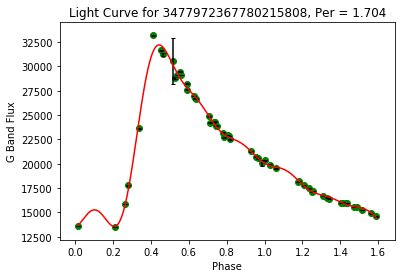

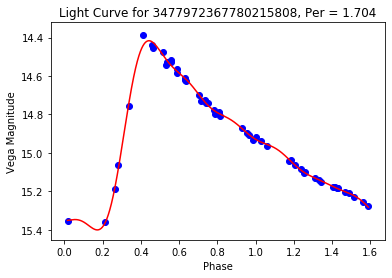

C_mag = 14.982318481469383
C_flux = 20023.80543044584
Conversion = -25.688365725119546
C_flux_converted = 14.934499183570967
int_avg_mag = 14.949039542984625


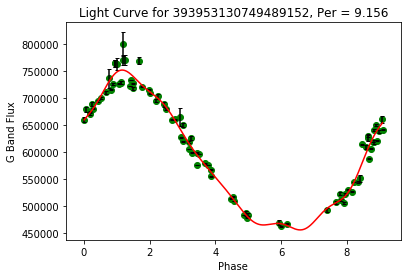

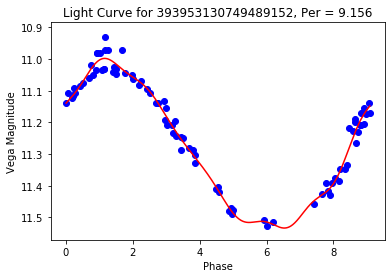

C_mag = 11.288360024557472
C_flux = 583567.252718027
Conversion = -25.688365725119546
C_flux_converted = 11.273138442198329
int_avg_mag = 11.28036520478319


In [129]:
files = glob.glob('lcs_*.txt')
for i in range(0, len(files)):
    SevDegFit(files[i])

## Comparing my Calculated Average Magnitude with the Published Magnitude

In [10]:
r['int_average_g'][np.argwhere(r['source_id']==3046774762417915136)]

7.830550402788656


## Conversion Factor Example

In [12]:
fluxy = 1.3344499230519688E7
fluxylog = -2.5*np.log10(fluxy)
magy = 7.875110022692443
fluxylog - magy

-25.688365725119546

## Sorting Light Curves by Length

In [74]:
def SortLC(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]   
    ceph_sources = np.loadtxt('vari_cepheids.txt', dtype=np.int64)
    lengths = []
    for i in range(0, len(ceph_sources)):
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        per = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per = per[0][0]
        if str(per) == '--':
            continue
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        #if len(G_ind) == 0:
            #continue
        time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        length = len(time_G)
        lengths.append([length,ceph_sources[i]])
        #return (len(time_G), ceph_sources[i])
        print(str(ceph_sources[i])+' = '+str(len(time_G))+' in '+str(file))
    #return lengths

In [70]:
#SortLC('lcs_3044.txt')

In [77]:
files = glob.glob('lcs_*.txt')
for i in range(0, len(files)):
    SortLC(files[i])

2931247014102560000 = 28 in lcs_2930.txt
2932101334643047680 = 39 in lcs_2930.txt
2932737092877188352 = 30 in lcs_2930.txt
2933016781147478272 = 37 in lcs_2930.txt
2934255449716149760 = 29 in lcs_2930.txt
2934506447605426944 = 34 in lcs_2930.txt
2934712880912798464 = 29 in lcs_2930.txt
2936110669428633216 = 30 in lcs_2930.txt
2936165984303583360 = 38 in lcs_2930.txt
2936194782069439872 = 41 in lcs_2930.txt
2944769323492573184 = 24 in lcs_2937.txt
2964640144306230272 = 53 in lcs_2963.txt
2972082493697861504 = 54 in lcs_2963.txt
3001414478927472768 = 13 in lcs_2981.txt
3002879165853875968 = 17 in lcs_2981.txt
3005222633152619904 = 14 in lcs_2981.txt
3017789986635163520 = 16 in lcs_3013.txt
3019875313517493504 = 16 in lcs_3013.txt
3019875691474610176 = 17 in lcs_3013.txt
3023160963497689856 = 16 in lcs_3013.txt
3026471318138219392 = 67 in lcs_3013.txt
3027495856819349248 = 30 in lcs_3013.txt
3027827978047324544 = 30 in lcs_3013.txt
3027940437469882880 = 27 in lcs_3013.txt
3029525447899149